In [2]:
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity
import numpy as np
import pandas as pd
import itertools
from git import Repo
from unidiff import PatchSet
from io import StringIO
import os
import dotenv

import tiktoken
encoding = tiktoken.encoding_for_model("text-embedding-ada-002")

dotenv.load_dotenv()
assert len(os.getenv("OPENAI_API_KEY", "")) > 0
openai.api_key = os.getenv("OPENAI_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "false"



In [3]:
repo = Repo('.cache/postgres')
c = next(repo.iter_commits())
diff_text = repo.git.diff(c.hexsha+'~1', c.hexsha, ignore_blank_lines=True, ignore_all_space=True)
patch_set = PatchSet(StringIO(diff_text))

In [4]:
MIN_HUNK_COUNT = 16 # need enough to do a train/test split
MAX_HUNK_SIZE = 20000 # should keep us under 8k tokens

def get_test_cases(repo, commit_count):
    """ Return an iterator of (sha, hunks) """
    repo = Repo(repo)
    matching_commits = {}
    for _, c in zip(range(commit_count), repo.iter_commits()):
        diff_text = repo.git.diff(c.hexsha+'~1', c.hexsha, ignore_blank_lines=True, ignore_all_space=True)
        if len(diff_text) == 0:
            continue
        diff_size = int(np.floor(np.log2(len(diff_text))))
        patch_set = PatchSet(StringIO(diff_text))
        if sum(len(h) for h in patch_set) < MIN_HUNK_COUNT:
            continue
        if any(any(len(str(h)) > MAX_HUNK_SIZE for h in hs) for hs in patch_set):
            continue
        for f in patch_set:
            k = (c.author, f.path, diff_size)
            l = matching_commits.setdefault(k, set())
            l.add(c.hexsha)
    seen = set()
    cases = []
    for cs in matching_commits.values():
        cs = cs - seen
        if len(cs) >= 3:
            cases.append(cs)
            seen.update(cs)
    return cases

test_cases_pg = get_test_cases('.cache/postgres', 1000)

In [5]:
test_cases_go = get_test_cases('.cache/go', 1000)

In [6]:
test_cases_sentry = get_test_cases('.cache/sentry', 1500)

In [7]:
len(test_cases_sentry)

13

In [8]:
def get_suites(pairs, format):
    out = {"suite": [], "hunk": [], "label": []}
    for repopath, cases in pairs:
        repo = Repo(repopath)
        for id, commits in enumerate(cases):
            hunks = [] # embeddings
            labels = []
            for i, sha in enumerate(commits):
                diff_text = repo.git.diff(sha+'~1', sha, ignore_blank_lines=True, ignore_all_space=True)
                patch_set = PatchSet(StringIO(diff_text))
                for f in patch_set:
                    for hunk in f:
                        out["suite"].append(os.path.basename(repopath) + ":" + str(id))
                        out["hunk"].append(format(f.path, hunk))
                        out["label"].append(i)
    return pd.DataFrame.from_dict(out)

In [9]:
import re
WHITESPACE = re.compile(r'\s+')

def fmt_plain(path, hunk):
    added = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_added])
    removed = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_removed])
    return f"""Path: {path}

Removed:
```
{removed}
```

Added:
```
{added}
```"""

In [10]:
suites = get_suites([('.cache/postgres', test_cases_pg), ('.cache/go', test_cases_go), ('.cache/sentry', test_cases_sentry)], fmt_plain)

In [11]:
suites

,suite,hunk,label
0,postgres:0,Path: contrib/amcheck/expected/check_heap.out\...,0
1,postgres:0,Path: contrib/amcheck/expected/check_heap.out\...,0
2,postgres:0,Path: contrib/amcheck/sql/check_heap.sql\n\nRe...,0
3,postgres:0,Path: contrib/amcheck/sql/check_heap.sql\n\nRe...,0
4,postgres:0,Path: doc/src/sgml/monitoring.sgml\n\nRemoved:...,0
...,...,...,...
4550,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2
4551,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2
4552,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2
4553,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2


In [12]:
# Number of examples (hunks) per class (commit)
suites.groupby(['suite', 'label']).hunk.apply(len).groupby('suite').agg(
    classes=len,
    mean=lambda x: round(np.mean(x)),
    min=np.min,
    max=np.max,
)

,classes,mean,min,max
suite,,,,
go:0,3,19,16,22
go:1,3,44,36,50
go:2,4,59,37,73
go:3,4,20,16,22
go:4,3,63,34,80
go:5,3,52,23,68
go:6,3,22,17,33
postgres:0,3,31,22,46
postgres:1,3,28,18,33


In [13]:
# Token count of examples (hunks) per suite
suites['token_count'] = suites.hunk.apply(lambda h: len(encoding.encode(h)))
suites.groupby('suite').token_count.agg(
    hunks=len,
    mean=lambda x: round(np.mean(x)),
    min=np.min,
    max=np.max,
)

,hunks,mean,min,max
suite,,,,
go:0,57,120,38,461
go:1,132,67,22,152
go:2,236,151,23,1767
go:3,78,86,29,1192
go:4,190,63,23,772
go:5,156,68,28,510
go:6,67,74,29,296
postgres:0,93,113,26,1020
postgres:1,84,158,29,1540


total: 407935 cost: $0.041 avg: 89.5576289791438 med: 53.0


<Axes: >

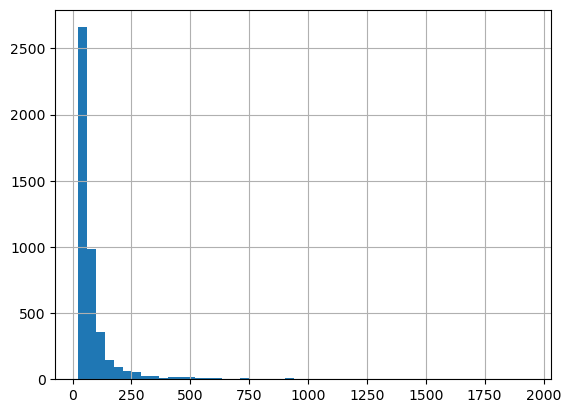

In [16]:
print(f'total: {suites.token_count.sum()} cost: ${round(suites.token_count.sum() * 0.0001) / 1000} avg: {suites.token_count.mean()} med: {suites.token_count.median()}')
suites.token_count.hist(bins=50)

In [77]:
suites['embedding'] = suites.hunk.apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))

In [105]:
suites[suites['embedding'].apply(len) != 1536]

,suite,hunk,label,token_count,embedding
1014,go:0,Path: src/cmd/internal/obj/mips/asm0.go\n\nRem...,1,129,[nan]


In [111]:
suites.at[1014, 'embedding'] = get_embedding(suites.at[1014, 'hunk'], engine='text-embedding-ada-002')

In [112]:
suites['embedding'].apply(len).min()

1536

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def test_classifiers(X, y):
    results = {}
    svm_scores = cross_val_score(SVC(), X, y, scoring='accuracy')
    results['classification'] = svm_scores.mean()

    clustering_model = KMeans(
        n_clusters=len(np.unique(y)), n_init="auto"
    )
    clustering_model.fit(X)
    cluster_assignment = clustering_model.labels_
    v_measure = v_measure_score(y, cluster_assignment)
    results["clustering"] = v_measure

    return results

def test_suite(df, suite):
    df = df[df['suite'] == suite]
    return test_classifiers(np.array(df.embedding.to_list()), np.array(df.label.to_list()))

def test_all_suites(df):
    suites = np.unique(df.suite)
    results = [{'suite': s, **test_suite(df, s)} for s in suites]
    return pd.DataFrame.from_records(results)

# results = test_all_suites(suites)

In [18]:
# summ = results.drop('suite', axis=1).mean()
# summ.to_dict()

In [36]:
REPO_COMMITCOUNTS = {'.cache/postgres': 1000, '.cache/go': 1000, '.cache/sentry': 1500}

def evaluate(embed, format):
    fname = format.__name__
    ename = embed.__name__
    cost_per_1k = embed.cost_per_1k
    print(f"evaluating formatter={fname} embedder={ename}")
    dfname = f'.cache/{ename}-{fname}-embeddings.pickle'
    try:
        suites = pd.read_pickle(dfname)
        print(f"loaded cached embeddings from {dfname}")
    except FileNotFoundError:
        print(f"generating test suite using formatter {fname}")
        commitgroups = [get_test_cases(repo, count) for repo, count in REPO_COMMITCOUNTS.items()]
        suites = get_suites(list(zip(REPO_COMMITCOUNTS.keys(), commitgroups)), format)
        suites['token_count'] = suites.hunk.apply(lambda h: len(encoding.encode(h)))
        
        print(f"generating embeddings using embedder {ename}")
        cost = round(suites.token_count.sum() * cost_per_1k) / 1000
        print(f'cost: ${cost}')
        if cost > 0.10:
            raise ValueError("unexpected cost")
        suites['embedding'] = suites.hunk.apply(embed)
        suites.to_pickle(dfname)
        print(f"wrote test suites & embeddings to {dfname}")
    print("evaluating")
    results = test_all_suites(suites)
    resname = f'.cache/{ename}-{fname}-results.pickle'
    results.to_pickle(resname)
    print(f"wrote test results {resname}")
    results['repo'] = results.suite.apply(lambda s: s.split(':')[0])
    summ = results.groupby('repo').clustering.mean()
    print(summ)
    return summ.to_dict()

In [39]:
import re
WHITESPACE = re.compile(r'\s+')

def fmt_diff(path, hunk):
    return path + "\n" + str(hunk) + "\n"

def fmt_plain(path, hunk):
    added = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_added])
    removed = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_removed])
    return f"""Path: {path}

Removed:
```
{removed}
```

Added:
```
{added}
```"""

def fmt_plain_flip(path, hunk):
    added = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_added])
    removed = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_removed])
    return f"""Path: {path}

Added:
```
{added}
```

Removed:
```
{removed}
```"""

def fmt_plain_hdr(path, hunk):
    added = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_added])
    removed = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_removed])
    return f"""Filename: {path}

Function: {hunk.section_header}

Removed:
```
{removed}
```

Added:
```
{added}
```"""

def fmt_plain_nofile(path, hunk):
    added = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_added])
    removed = "\n".join([WHITESPACE.sub(' ', l.value.strip()) for l in hunk if l.is_removed])
    return f"""Removed:
```
{removed}
```

Added:
```
{added}
```"""

In [21]:
def embed_openai_ada(text):
    return get_embedding(text, engine='text-embedding-ada-002')

embed_openai_ada.cost_per_1k=0.0001

In [22]:
from FlagEmbedding import FlagModel

bge_large_en = FlagModel('BAAI/bge-large-en')

def embed_bge_large_en(text):
    return bge_large_en.encode(text)

embed_bge_large_en.cost_per_1k = 0

In [32]:
from sentence_transformers import SentenceTransformer

gte_large = SentenceTransformer('thenlper/gte-large')

def embed_gte_large(text):
    return gte_large.encode(text)

embed_gte_large.cost_per_1k = 0

In [47]:
from InstructorEmbedding import INSTRUCTOR

instructor_xl = INSTRUCTOR('hkunlp/instructor-xl')
instruction = "Represent the code change for clustering:"

def embed_instructor_xl(text):
    return instructor_xl.encode([[instruction,text]])[0]

embed_instructor_xl.cost_per_1k = 0

load INSTRUCTOR_Transformer
max_seq_length  512


In [31]:
from sentence_transformers import SentenceTransformer
e5_large_v2 = SentenceTransformer('intfloat/e5-large-v2')

def embed_e5_large_v2(text):
    return e5_large_v2.encode(text)

embed_e5_large_v2.cost_per_1k = 0

In [50]:
records = []
for embed in [embed_openai_ada, embed_bge_large_en, embed_gte_large, embed_instructor_xl, embed_e5_large_v2]:
    for format in [fmt_plain, fmt_plain_flip, fmt_plain_hdr]:
        records.append(dict(embedding=embed.__name__, formatter=format.__name__, **evaluate(embed, format)))
results = pd.DataFrame.from_records(records)
results 

evaluating formatter=fmt_plain embedder=embed_openai_ada
loaded cached embeddings from .cache/embed_openai_ada-fmt_plain-embeddings.pickle
evaluating
wrote test results .cache/embed_openai_ada-fmt_plain-results.pickle
repo
go          0.603285
postgres    0.417082
sentry      0.308722
Name: clustering, dtype: float64
evaluating formatter=fmt_plain_flip embedder=embed_openai_ada
loaded cached embeddings from .cache/embed_openai_ada-fmt_plain_flip-embeddings.pickle
evaluating
wrote test results .cache/embed_openai_ada-fmt_plain_flip-results.pickle
repo
go          0.617202
postgres    0.392912
sentry      0.339857
Name: clustering, dtype: float64
evaluating formatter=fmt_plain_hdr embedder=embed_openai_ada
loaded cached embeddings from .cache/embed_openai_ada-fmt_plain_hdr-embeddings.pickle
evaluating
wrote test results .cache/embed_openai_ada-fmt_plain_hdr-results.pickle
repo
go          0.495829
postgres    0.377645
sentry      0.262315
Name: clustering, dtype: float64
evaluating forma

,embedding,formatter,go,postgres,sentry
0,embed_openai_ada,fmt_plain,0.603285,0.417082,0.308722
1,embed_openai_ada,fmt_plain_flip,0.617202,0.392912,0.339857
2,embed_openai_ada,fmt_plain_hdr,0.495829,0.377645,0.262315
3,embed_bge_large_en,fmt_plain,0.577139,0.340953,0.329205
4,embed_bge_large_en,fmt_plain_flip,0.438331,0.296929,0.244960
5,embed_bge_large_en,fmt_plain_hdr,0.363113,0.320373,0.199980
6,embed_gte_large,fmt_plain,0.487651,0.301250,0.213855
7,embed_gte_large,fmt_plain_flip,0.421312,0.325795,0.237820
8,embed_gte_large,fmt_plain_hdr,0.353029,0.277304,0.148922
9,embed_instructor_xl,fmt_plain,0.526723,0.389988,0.295506


In [51]:
results.sort_values(by='go')

,embedding,formatter,go,postgres,sentry
8,embed_gte_large,fmt_plain_hdr,0.353029,0.277304,0.148922
5,embed_bge_large_en,fmt_plain_hdr,0.363113,0.320373,0.199980
7,embed_gte_large,fmt_plain_flip,0.421312,0.325795,0.237820
11,embed_instructor_xl,fmt_plain_hdr,0.424955,0.323518,0.253529
4,embed_bge_large_en,fmt_plain_flip,0.438331,0.296929,0.244960
14,embed_e5_large_v2,fmt_plain_hdr,0.438338,0.344374,0.245095
13,embed_e5_large_v2,fmt_plain_flip,0.483632,0.354722,0.291356
6,embed_gte_large,fmt_plain,0.487651,0.301250,0.213855
2,embed_openai_ada,fmt_plain_hdr,0.495829,0.377645,0.262315
10,embed_instructor_xl,fmt_plain_flip,0.500429,0.346324,0.251742


In [43]:
df = pd.read_pickle('.cache/embed_instructor_xl-fmt_plain-embeddings.pickle')

In [44]:
df

,suite,hunk,label,token_count,embedding
0,postgres:0,Path: contrib/amcheck/expected/check_heap.out\...,0,53,"[[0.041450348, 0.035152152, 0.004856052, 0.015..."
1,postgres:0,Path: contrib/amcheck/expected/check_heap.out\...,0,53,"[[0.041450348, 0.035152152, 0.004856052, 0.015..."
2,postgres:0,Path: contrib/amcheck/sql/check_heap.sql\n\nRe...,0,52,"[[0.040087167, 0.054121498, 0.0010639039, 0.01..."
3,postgres:0,Path: contrib/amcheck/sql/check_heap.sql\n\nRe...,0,52,"[[0.040087167, 0.054121498, 0.0010639039, 0.01..."
4,postgres:0,Path: doc/src/sgml/monitoring.sgml\n\nRemoved:...,0,57,"[[0.061552793, -0.012788772, 0.010033857, 0.00..."
...,...,...,...,...,...
4550,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2,57,"[[0.09964518, 0.03305289, 0.014494304, -0.0463..."
4551,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2,37,"[[0.110374086, 0.02242736, 0.020871252, -0.043..."
4552,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2,571,"[[0.054125663, 0.060060814, 0.03830055, -0.041..."
4553,sentry:12,Path: static/app/views/onboarding/setupDocs.ts...,2,38,"[[0.055262994, 0.022723034, 0.03650539, -0.020..."
